# Analysis of dynamical polarizability of $N_2$ in the linear response formalism

We analyze the computation of the dynamical polarizability inside the linear response formalism.

The aim of this notebook is to:

* compute the Casida matrix associated to the highest value of virtual orbitals. 
* build the matrices associated to a lower number of virtual orbitals (by extracting its elements from the highest one) and discuss the rate of convergence of the statical polarizability to the reference value (formerly computed by including an explicit electric field). 
* evaluate the dynamical polarizability spectrum and discuss its stability in function of the number of virtual orbitals considered.  

In [52]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


Set up of the main parameters

In [53]:
rVal = [7.0, 9.0]
virtMax = [303, 279]

### Computation of the coupling matrix and transition dipoles

In [54]:
inp0 = {'dft' : 
        {'hgrids': 0.40,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [55]:
for ind,r in enumerate(rVal):
    inp={'dft': {'rmult': [r, 9.0], 'itermax_virt' : 1},
         'output': {'orbitals' : 'No', 'verbosity' : 3}, 
         'radical': 'Rmult_'+str(r)}

    inp['dft']['norbv'] = -virtMax[ind]
    inpname = 'Rmult_'+str(r)+'_numVirt_'+str(virtMax[ind])
    Yaml.dump(inp,outputpath + inpname + '.yaml')

We execute the input file and copy the coupling matrix and transition dipoles in the "TDDFT-Results" folder

In [56]:
rmultInd = 1
print 'Run computation for rmult = ', rVal[rmultInd]

code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
inpname = 'Rmult_'+str(rVal[rmultInd])+'_numVirt_'+str(virtMax[rmultInd])
code.run(name=inpname,skip=True,outdir='./log/')
%cd ../

Run computation for rmult =  9.0
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -n Rmult_9.0_numVirt_279 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


## Data analysis

Read the dipoles and coupling matrix (for a single value of rVal specified by rmultInd)

In [64]:
rmultInd = 1
print 'Read data for rmult = ', rVal[rmultInd]
print 'Maximum value of virtual orbitals = ', virtMax[rmultInd]
print ''

%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_rmult'+str(rVal[rmultInd])+'_numVirt'+str(virtMax[rmultInd])+'.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_rmult'+str(rVal[rmultInd])+'_numVirt'+str(virtMax[rmultInd])+'.txt'
Cmat = np.loadtxt(cpath)
%cd ..

Read data for rmult =  9.0
Maximum value of virtual orbitals =  279

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


We observe that $C$ is a symmetric matrix

In [65]:
np.allclose(Cmat,Cmat.T,atol=1.e-12)

True

In [66]:
numOrb = 5
nalpha = [16,32,64,96,128,160,192,224,256,virtMax[rmultInd]]
nalpha

[16, 32, 64, 96, 128, 160, 192, 224, 256, 279]

In [67]:
reload(R)
eigenproblems = R.solveEigenProblems(numOrb,virtMax[rmultInd],Cmat,dipoles,nalpha)

(160, 160)
(320, 320)
(640, 640)
(960, 960)
(1280, 1280)
(1600, 1600)
(1920, 1920)
(2240, 2240)
(2560, 2560)
(2790, 2790)


In [68]:
eigenproblems.keys()

[32, 128, 64, 96, 160, 192, 224, 256, 16, 279]

### Analysis of the statical polarizability

We discuss the convergence of the static polarizability to its reference value obtained with the explicit electric field.

In [69]:
reload(R)
statPol = R.evalStatPol(eigenproblems)
statPol[virtMax[rmultInd]]

[10.643700998141032, 10.643701005208033, 15.092620758654903]

In [70]:
statPol_ref = [10.87,10.87,15.736]

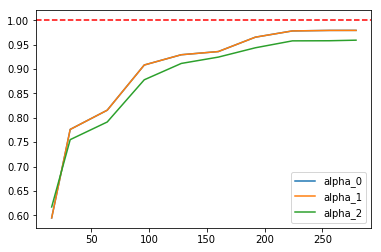

In [72]:
for x in range(3):
    val = []
    for na in nalpha:
        val.append(statPol[na][x])
    val = np.array(val)/statPol_ref[x]
    plt.plot(nalpha,val,label='alpha_'+str(x))
plt.axhline(y=1.0, color='r', linestyle='--')
plt.legend()
plt.show()

To check the correctness of the procedure for the construcion of the coupling matrix (given the one with the highest number of virtual orbitals) we compare some of the result (only for rmult = 7) obtained above with the ones build in terms of the true coupling matrix computed with 16 virtual orbitals.

In [50]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_rmult7.0_numVirt16.txt'
dipoles_16 = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_rmult7.0_numVirt16.txt'
C_16 = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [51]:
eigenproblems_16 = R.solveEigenProblems(numOrb,16,C_16,dipoles_16,[16])
statPol_16 = R.evalStatPol(eigenproblems_16)
print statPol_16[16]
print statPol[16]

(160, 160)
[7.3652949235158021, 7.3652950885610453, 11.059355580932314]
[7.3652950119485476, 7.3652950119485903, 11.059355520654851]


### Dynamical polarizability in the adiabatic case

for na =  192  numpoint =  345  omegaMax =  1.72681211035
for na =  256  numpoint =  366  omegaMax =  1.83111462488
for na =  279  numpoint =  384  omegaMax =  1.92260078949


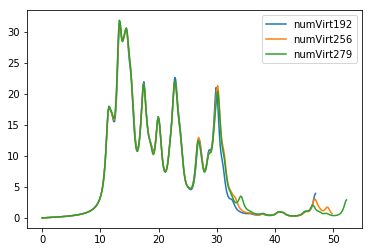

In [73]:
reload(R)
nalphaPlot = [192,256,virtMax[rmultInd]]
spectrum = R.evalSpectrum(eigenproblems,nalphaPlot)
for na in nalphaPlot:
    plt.plot(spectrum[na]['omega'],spectrum[na]['imagPart'],label='numVirt'+str(na))
plt.legend()
#plt.xlim(0,50)
plt.show()

We write the spectrum dictionary on file

In [74]:
print 'Write spectrum data for rmult = ', rVal[rmultInd]
spToFile = {}
for na, s in spectrum.iteritems():
    spToFile[na] = {'omega': spectrum[na]['omega'].tolist(), 'realPart':spectrum[na]['realPart'].tolist(), 'imagPart':spectrum[na]['imagPart'].tolist()}
filename = outputpath+'log/spectrum_rmult_'+str(rVal[rmultInd])+'.yaml '
Yaml.dump(spToFile,filename)

Write spectrum data for rmult =  9.0
